In [1]:
# RUN THIS FILE FIRST

import os
import struct
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [2]:
# Paths
# adjust these two 
mnist_path = "/Users/thomasklein/Uni/5. Semester/TensorFlow/Hausaufgaben/MNIST/MNIST_data" # path to data, might be different from source code location
global_path = "/Users/thomasklein/Uni/5. Semester/TensorFlow/final task/" # main folder

# are already relative to main folder
logs_path = global_path+"Summaries/" # summary data for Tensorboard goes here
save_path = global_path+"Checkpoints/" # Checkpoints of Saver Class go here
datagraph_path = global_path+"graph_data/" # network performance values are stored here to be plotted later
samples_path = global_path+"Samples_Simple/" # adversarial samples to be applied to the CNN later are stored here

In [3]:
# The MNIST-helper-class, as provided by Lukas for one of the first tensorflow-tasks. The only difference is that we
# scaled the data to be between 0 and 1 instead of 0 and 255, because otherwise, we need to scale our epsilon.

class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("train-images-idx3-ubyte")
        self._training_labels = self._load_binaries("train-labels-idx1-ubyte")
        self._test_data = self._load_binaries("t10k-images-idx3-ubyte")
        self._test_labels = self._load_binaries("t10k-labels-idx1-ubyte")
   
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]/255, labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
    def get_one_image(self):
        index = np.random.choice(len(self._training_data), replace = False)
        img = self._training_data[index].flatten()
        label = self._training_labels[index]
        return img
    
    def show_image(self):
        """
        Randomly chooses one image from the training data and displays both the image and the
        corresponding label.
        """
        index = np.random.choice(len(self._training_data), replace = False)
        img = self._training_data[index]
        label = self._training_labels[index]
        
        plt.figure()
        plt.imshow(img)
        plt.show()
        
        print("Label:  ", label)
        return img
    
mnist = MNIST(mnist_path)

In [4]:
# The Data Flow Graph for our first experiment: classifying handwritten digits using a single feed forward layer.
# We have a 784x10 weight matrix and ten biases to project all MNIST-pixels onto ten neurons. No activation function,
# as the drive is put directly into a softmax function that is computed in the sparse_softmax_cross_entropy

tf.reset_default_graph()

input_img = tf.placeholder(tf.float64,[None,28,28], "x") # placeholder for image
flattened = tf.reshape(input_img, [-1, 28*28])           # reshaping to one vector per image
labels = tf.placeholder(tf.int64,[None], "y")            # placeholder for correct labels

weights = tf.Variable(np.random.normal(0, 0.000002,(784,10)))   # 784x10 weight matrix
bias = tf.Variable(np.zeros(10))                                # 10 biases

drive = tf.matmul(flattened,weights)+bias     # drive of output layer

drive_sum = tf.reduce_sum(drive)             # not needed for DFG, only to gain insights later
softmax = tf.nn.softmax(drive)          # not needed for DFG, only to gain insights later  

predicted_label = tf.argmax(drive, axis=1)   # predicted label is the one with highest activation

accu = tf.equal(labels, predicted_label)                           # calculating the accuracy
accuracy = tf.reduce_sum(tf.cast(accu,tf.int32))/tf.size(labels)
summary_accuracy = tf.summary.scalar("Accuracy", accuracy)         # using tensorboard

# applying softmax to the drive and calculating cross entropy between prediction and ground truth
cross_entropies = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = drive, labels = labels)
mean_cross_entropy = tf.reduce_mean(cross_entropies)     # calculating the mean cross entropy for the mini-batch 
tf.summary.scalar("Cross_Entropy", mean_cross_entropy)   # using tensorboard

summary_node = tf.summary.merge_all() # merging all summary nodes

# we tried different optimizers, Adagrad worked rather well
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.train.AdagradOptimizer(0.0002)
optimization_step = optimizer.minimize(mean_cross_entropy) # training the network in the usual fashion

# to generate adversarial examples using the fast gradient sign method, we need to calculate the gradient of the loss
# with respect to the input image. tf.gradient does just that, yielding a matrix with same dimensions as training images
gradients = tf.gradients(mean_cross_entropy,input_img)


In [5]:
# Training the network. We use batches of size 50 and 3 episodes. Cross entropy and accuracy of the resulting 
# predictions are monitored using TensorBoard.

batch_size = 50
episodes = 3

with tf.Session() as session:
    
    session.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(logs_path+"regular_model", session.graph)
    
    step = 0
    for episode in range(episodes):
        for batch, label in mnist.get_training_batch(batch_size):
            
            run_metadata = tf.RunMetadata() # seems to be necessary for filewriter
            
            # performing one optimization step per batch, writing a summary
            label = np.int64(label)
            _opt_step, _summary = session.run([optimization_step, summary_node], 
                                              feed_dict={input_img:batch, labels:label})
            
            writer.add_run_metadata(run_metadata, 'step'+str(step))
            writer.add_summary(_summary, step)
            
            step = step + 1
            
    # regular model now refers to a simple regression model trained without adversarial samples         
    regular_model = saver.save(session, save_path+"regular.ckpt", global_step = step)


In [6]:
def generate_adversarial(session, epsilon, batch, label):
    """
    Generates an adversarial example using the fast gradient sign method.
    
    session = the tensorflow session to be used
    epsilon = the epsilon for the disturbance
    batch   = the training batch containing one image (batch with one element)
    label   = the real label of batch
    
    Returns an adversarial image with same dimensions as original image.
    """
    _gradient = session.run([gradients], feed_dict={input_img:batch, labels:label})
    
    eta = []
    for grad in _gradient:
        eta.append(epsilon * np.sign(grad))

    eta = np.reshape(np.array(eta),[28,28]) # match image dimensions

    adversarial = batch[0]+eta
    
    return adversarial

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regular.ckpt-3240


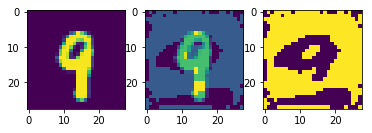

Predicted Label: [8]
Drive for undisturbed image: -0.7738943784646237
Drive for adversarial example: -1.2605720456458742
Difference in drives: 0.4866776671812505


In [7]:
# Generating and printing an adversarial example together with its original image.

epsilon = 0.2
with tf.Session() as session:
    
    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)

    #plt.figure() 
    for batch, label in mnist.get_training_batch(1):
        # batch is one image, label one number
        
        # receiving the gradients, the drive and the target class probabilities for the image
        # not using our method because we also need those other values, but same code otherwise
        _gradient, _sum, _prob = session.run([gradients,drive_sum, softmax], 
                                             feed_dict={input_img:batch, labels:label})
        
        # the class probabilities for the original image
        #print("Class Probabilities for undisturbed image:\n", _prob)
        
        # calculating the perturbation that will be applied to the image
        eta = []
        for grad in _gradient:
            eta.append(epsilon * np.sign(grad))
            
        eta = np.reshape(np.array(eta),[28,28]) # reshaping eta to match image dimensions

        # generating the adversarial example
        adversarial = batch[0]+eta
        
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(batch[0])    # printing the original image 
        axarr[1].imshow(adversarial) # printing the adversarial
        axarr[2].imshow(eta)         # printing the perturbation
        plt.show()
        
        # feeding the adversarial sample into the network to see what it predicts
        _pred_label, _dis_sum, _dis_prob = session.run([predicted_label, drive_sum, softmax], 
                                                       feed_dict={input_img:np.reshape(adversarial, [1,28,28])})
        
        print("Predicted Label:",_pred_label) # should be different from actual label
        
        # the drive is what is changed by the fast gradient sign method
        print("Drive for undisturbed image:", _sum)
        print("Drive for adversarial example:",_dis_sum) 
        
        print("Difference in drives:",np.absolute(_dis_sum-_sum))   # looking at the difference
        
        #print("Class Probabilities for adversarial example:\n",_dis_prob)   # predicted probabilities
        
                
        break

In [8]:
# generating batch of adversarial examples to calculate a stable value for the network accuracy.
# In our tests, the network was always fooled more than 95% of the time.
# The value for Epsilon is exactly the one used in Goodfellow's paper.

epsilon = 0.25
samples = 1000
adversarials = [] # used to store samples
real_labels = []  # used to store labels of samples

# measuring ssim between original and adversarial to obtain average difference as metric
from skimage.measure import compare_ssim as ssim

with tf.Session() as session:
    
    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)
    
    ssim_difference = 0 # structural similarity index
    mad = 0 # mean absolute difference
    
    number = 0 # just a counter for how many samples were generated yet
    for batch, label in mnist.get_training_batch(1):
        # batch is one image, label one number
        
        adversarial = generate_adversarial(session, epsilon, batch, label)
        
        ssim_difference += ssim(np.reshape(batch,(28,28)), adversarial,
                               data_range= adversarial.max()-adversarial.min())
        
        mad += np.mean(np.abs(np.reshape(batch,(28,28)) - adversarial))
        
        adversarials.append(adversarial)
        real_labels.append(label)
        
        if( number == samples):
            break
        number = number + 1
        
    print("Average structural similarity between original and adversarial:",ssim_difference/number)
    # MAD should equal epsilon, within some margin of error
    print("Mean absolute difference between original and adversarial:",mad/number)
        
    # measuring performance on adversarial examples
    correct = 0
    for index, adversarial in enumerate(adversarials):
        
        l = np.int64(real_labels[index])
        _predicted_label = session.run(predicted_label, 
                                            feed_dict={input_img:np.reshape(adversarial, [1,28,28]), labels:l})
        
        # uncomment this to see direct comparison of real and predicted label, should be wrong all the time
        #print("predicted:", _predicted_label, "real:", real_labels[index])
        
        if(_predicted_label == real_labels[index]): # prediction was correct
            correct = correct + 1
    
    print("Accuracy with epsilon",epsilon,"was",correct/samples, "which means that the adversarial worked",(1-(correct/samples))*100,"% of the time.")
    

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regular.ckpt-3240
Average structural similarity between original and adversarial: 0.4530332708043961
Mean absolute difference between original and adversarial: 0.25025
Accuracy with epsilon 0.25 was 0.039 which means that the adversarial worked 96.1 % of the time.


INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regular.ckpt-3240


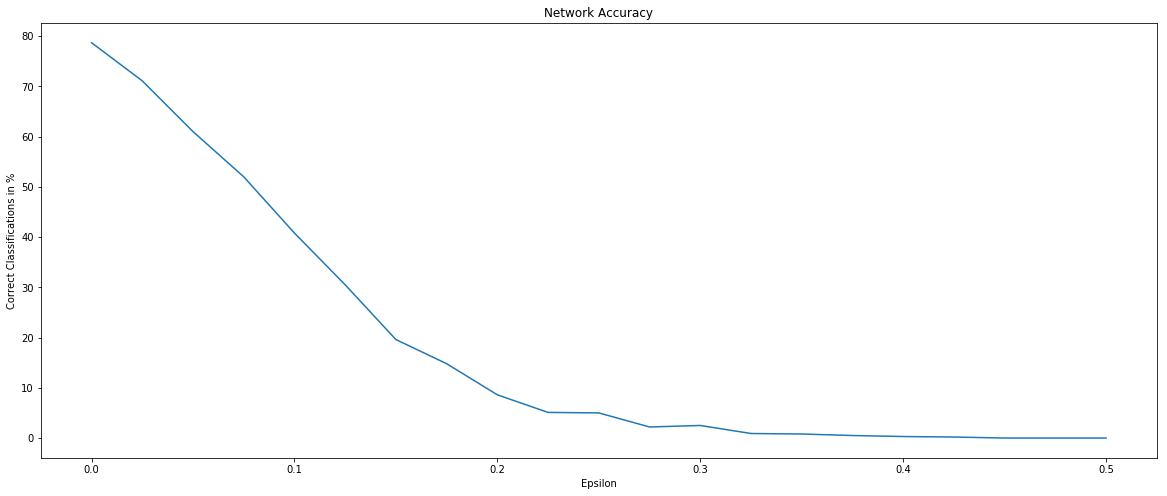

In [9]:
# exploring different values for epsilon, starting at zero, going up to .5

samples_per_epsilon = 1000 # how many samples to generate for each epsilon

with tf.Session() as session:

    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)
    
    # used for storing values for plotting 
    xvals = []
    yvals = []
    
    for i in range(21): # 2.5 percent steps
        epsilon = i * 0.025
        
        number = 0
        correct = 0
        
        for batch, label in mnist.get_test_batch(1):
            
            # generating an adversarial example
            adversarial = generate_adversarial(session, epsilon, batch, label)
            
            # making a prediction
            label = np.int64(label)
            _predicted_label = session.run(predicted_label, 
                                            feed_dict={input_img:np.reshape(adversarial, [1,28,28]), labels:label})
        
            if(_predicted_label == label): # prediction was correct
                correct = correct + 1
            
            # we have generated enough samples
            if(number == samples_per_epsilon):
                
                xvals.append(epsilon)
                yvals.append(correct/samples_per_epsilon*100)#(((1-(correct/samples_per_epsilon))*100))
                
                # uncomment this to see which epsilon value caused which percentage of missclassifications
                #print("Epsilon of %.2f" % epsilon,"fooled the network %.2f" % ((1-(correct/samples_per_epsilon))*100),"% of the time.")
                break
                
            number = number + 1
    
    # storing values for regular simple model
    output = open(datagraph_path+"regularSimple.pkl", 'wb')
    pickle.dump(yvals, output, -1)
    output.close()
    
    # plotting results
    plt.figure(figsize=(20,8))
    plt.plot(xvals,yvals)
    plt.ylabel("Correct Classifications in %")
    plt.xlabel("Epsilon")
    plt.title("Network Accuracy")
    plt.show()

In [10]:
# preparation for adversarial training. We generate 54.000 adversarial samples and keep them in a list.
# we also store the first 1.000 adversarial examples, to use them later for the CNN.

epsilon = 0.25
batchsize = 50
adversarials = [] # used to store samples
real_labels = []  # used to store labels of samples

save_adversarials = []
save_labels = []


with tf.Session() as session:
    
    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)
    
    writer = tf.summary.FileWriter(logs_path+"Adversarial_Training", session.graph)
    
    counter = 0
    # generate 54.000 adversarial samples
    for batch, label in mnist.get_training_batch(1):
        # batch is one image, label one number
        adversarial = generate_adversarial(session, epsilon, batch, label)
        # if this is one of the first 1000 images, append it to storage list
        if(counter < 1000):
            save_adversarials.append(adversarial)
            save_labels.append(label)
        adversarials.append(adversarial)
        real_labels.append(label)
        counter += 1
        
# serialize storage lists using cpickle
output = open(samples_path+"adversarials.pkl", 'wb')
pickle.dump(save_adversarials, output, -1)
output.close()

output = open(samples_path+"labels.pkl",'wb')
pickle.dump(save_labels, output, -1)
output.close()
    

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regular.ckpt-3240


In [11]:
# ADVERSARIAL TRAINING
# we train the network using 50% real images and 50% adversarial samples that were generated from the training set.

with tf.Session() as session:
    # reset the network
    session.run(tf.global_variables_initializer())
    
    
    step = 0
    episodes = 3
    batchsize = 25
    
    for e in range(episodes):
        
        begin = 0
        end = batchsize
        
        for batch, label in mnist.get_training_batch(batchsize): # using training set
            
            # doubling the size of the batch by adding just as many adversarial samples
            batch = np.append(batch, adversarials[begin:end], axis=0)
            label = np.append(label, real_labels[begin:end])
            run_metadata = tf.RunMetadata()

            _opt_step, _summary = session.run([optimization_step, summary_node], feed_dict={input_img:batch, labels:np.int64(label)})

            writer.add_run_metadata(run_metadata, 'step'+str(step))
            writer.add_summary(_summary, step)

            step = step + 1

            begin += batchsize
            end += batchsize
            
    # adversarial model now contains a regression model that was trained on adversarial samples
    adversarial_model = saver.save(session, save_path+"adversarial.ckpt", global_step = step)

In [ ]:
# same test again with network that went through adversarial training
# different values for epsilon, starting at zero, going up to .5

samples_per_epsilon = 1000 # how many samples to generate for each epsilon

with tf.Session() as session:

    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  adversarial_model)
    
    # used for storing values for plotting 
    xvals = []
    yvals = []
    
    for i in range(21): # 2.5 percent steps
        epsilon = i * 0.025
        
        number = 0
        correct = 0
        
        for batch, label in mnist.get_test_batch(1):
            
            # generating an adversarial example
            adversarial = generate_adversarial(session, epsilon, batch, label)
            
            # making a prediction
            label = np.int64(label)
            _predicted_label = session.run(predicted_label, 
                                            feed_dict={input_img:np.reshape(adversarial, [1,28,28]), labels:label})
        
            if(_predicted_label == label): # prediction was correct
                correct = correct + 1
            
            # we have generated enough samples
            if(number == samples_per_epsilon):
                
                xvals.append(epsilon)
                yvals.append(correct/samples_per_epsilon*100)#(((1-(correct/samples_per_epsilon))*100))
                
                # uncomment this to see which epsilon value caused which percentage of missclassifications
                #print("Epsilon of %.2f" % epsilon,"fooled the network %.2f" % ((1-(correct/samples_per_epsilon))*100),"% of the time.")
                break
                
            number = number + 1
            
    # storing values for adversarial simple model
    output = open(datagraph_path+"adversarialSimple.pkl", 'wb')
    pickle.dump(yvals, output, -1)
    output.close()
    
    # plotting results
    plt.figure(figsize=(20,8))
    plt.plot(xvals,yvals)
    plt.ylabel("Correct Classifications in %")
    plt.xlabel("Epsilon")
    plt.title("Network Accuracy")
    plt.show()



INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/adversarial.ckpt-6480


## Summary ##
In this notebook, we introduced a simple linear regression model with a softmax output layer, trained it using the Adagrad-Optimizer and demonstrated how adversarial examples can be generated using the fast gradient sign method. 

Subsequently, we measured the performance of the network when presented with those adversarial examples. We were able to observe a failure rate of more than 95% for the value of epsilon that was suggested by the original paper. We then explored different values for epsilon, starting at zero and moving up to 0.5, always evaluating the performance of the network on adversarial examples that were generated from the test set. We were able to observe a strong correlation between the size of epsilon and the decline of network performance.

After that, we trained the same network (again initialized from random values) using a mixture of real and adversarial training images to obtain a network that should theoretically be able to resist adversarial examples. Surprisingly, this network performed even worse when presented with adversarial examples from the test set, which lead us to believe that the model is not capable of representing the function that would have been required to recognise adversarial examples. Given this observation, it is quite remarkable that the adversarially trained network converged rather well, certainly as good as without the adversarial examples. 